In [3]:
from sys import stdout
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import scipy
import nltk
import spacy
from copy import copy
from random import randint
from math import sqrt
from __future__ import division
import pickle
import time

import seaborn as sns
import warnings
from IPython.display import display

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split

import xgboost as xgb

%matplotlib inline
sns.set_style("darkgrid")

In [4]:
test = pd.read_csv('test.csv')
display(test.head())

train = pd.read_csv('train.csv')
display(train.head())

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
Xy = train.drop(['qid1', 'qid2', 'id'], axis=1).as_matrix() 
X = train.drop(['qid1', 'qid2', 'id', 'is_duplicate'], axis=1).as_matrix()
y = train['is_duplicate'].as_matrix()

print Xy
print X
print y

features = np.copy(X)

[['What is the step by step guide to invest in share market in india?'
  'What is the step by step guide to invest in share market?' 0]
 ['What is the story of Kohinoor (Koh-i-Noor) Diamond?'
  'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'
  0]
 [ 'How can I increase the speed of my internet connection while using a VPN?'
  'How can Internet speed be increased by hacking through DNS?' 0]
 ..., 
 ['What is one coin?' "What's this coin?" 0]
 [ 'What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?'
  'I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?'
  0]
 ['What is like to have sex with cousin?'
  'What is it like to have sex with your cousin?' 0]]
[['What is the step by step guide to invest in share market in india?'
  'What is the step by step guide to invest in share market?']
 ['What is the story of Kohinoor (Koh-i-Noor)

In [6]:
sample = Xy[np.random.choice(X.shape[0], 10000, replace=False), :]
print sample.shape

(10000, 3)


In [7]:
def equalize(tokens):
    stemmer = nltk.stem.PorterStemmer()
    stems = [(stemmer.stem(t)) for t in tokens]
    return stems

In [8]:
# sX, sy = sample[:, 0:2], sample[:, 2]
sX, sy = Xy[:, 0:2], Xy[:, 2]

toker = nltk.tokenize.RegexpTokenizer(r'((?<=[^\w\s])\w(?=[^\w\s])|(\W))+', gaps=True)

def clean(v):
    ans = []
    try:
        for word in toker.tokenize(v):
            if word not in nltk.corpus.stopwords.words('english') and word.isalpha() and len(word) > 2:
                ans.append(word.lower())
    except:
        pass
    
    return ans

# cl = []
# cleq = []
# lens = []

# for i, v in enumerate(sX):
#     stdout.write(str(i+1) + '/' + str(sX.shape[0]) + '\r')
#     cl.append([clean(v[0]), clean(v[1])])
#     cleq.append([equalize(cl[i][0]), equalize(cl[i][1])])
#     lens.append(abs(len(cl[i][0]) - len(cl[i][1])))

# cl, cleq = map(np.array, (cl, cleq))
# cl = np.array(cl)
 
with open('cleaned_train_matrix.pkl') as f:
    cl = pickle.load(f)
    
display(cl[15:20])
print '----'
print sX[15:20]

array([[ ['what', 'would', 'trump', 'presidency', 'mean', 'current', 'international', 'students', 'visa'],
        ['how', 'trump', 'presidency', 'affect', 'students', 'presently', 'planning', 'study']],
       [['what', 'manipulation', 'mean'], ['what', 'manipulation', 'means']],
       [['why', 'girls', 'want', 'friends', 'guy', 'reject'],
        ['how', 'guys', 'feel', 'rejecting', 'girl']],
       [ ['why', 'many', 'quora', 'users', 'posting', 'questions', 'readily', 'answered', 'google'],
        ['why', 'people', 'ask', 'quora', 'questions', 'answered', 'easily', 'google']],
       [['which', 'best', 'digital', 'marketing', 'institution', 'banglore'],
        ['which', 'best', 'digital', 'marketing', 'institute', 'pune']]], dtype=object)

----
[[ 'What would a Trump presidency mean for current international master\xe2\x80\x99s students on an F1 visa?'
  'How will a Trump presidency affect the students presently in US or planning to study in US?']
 ['What does manipulation mean?' 'What does manipulation means?']
 ['Why do girls want to be friends with the guy they reject?'
  'How do guys feel after rejecting a girl?']
 [ 'Why are so many Quora users posting questions that are readily answered on Google?'
  'Why do people ask Quora questions which can be answered easily by Google?']
 ['Which is the best digital marketing institution in banglore?'
  'Which is the best digital marketing institute in Pune?']]


In [9]:
def get_longest_common_substring(A, B):
    m, n = len(B), len(A)
    length= [[0 for x in range (m+1)]for x in range (n+1)]

    for i in range (1,n+1):
        for j in range (1, m+1):
            if A[i-1]==B[j-1]:
                length[i][j]=1+length[i-1][j-1]
            else:
                length[i][j]= length[i-1][j] if length[i-1][j]>length[i][j-1] else length[i][j-1]            


    index = length[n][m]
    p= copy(index)

    lcs= ['' for x in range (index)]
    i,j= n, m
    while i>0 and j>0:
        if A[i-1]== B[j-1]:
            lcs[index-1]= A[i-1]
            index=index-1
            i=i-1
            j=j-1

        elif length[i-1][j]> length[i][j-1]:
            i=i-1

        else:
            j=j-1
            
    return lcs


def create_commons(arr):    
    commons = []
    uniques = []
    scores = []
    
    for e, i in enumerate(arr):
        commons.append(get_longest_common_substring(i[0], i[1]))
        u1 = [j for j in i[0] if j not in commons[e]]
        u2 = [j for j in i[1] if j not in commons[e] and j not in u1]
        uniques.append(u1 + u2)
        
        try:
            scores.append( len(commons[e]) * (1/len(i[0]) + 1/len(i[1])) / 2)
        except ZeroDivisionError:
            if len(i[0]) == 0 and len(i[1]) > 0:
                s = len(commons[e]) *  1/len(i[1])
                
            elif len(i[1]) == 0 and len(i[0]) > 0:
                s = len(commons[e]) *  1/len(i[0])
            else:
                s = 0
            scores.append(s)
            
        stdout.write(str(e) + '/' + str(arr.shape[0]) + '\r')
    
    return map(np.array, (commons, uniques, scores))

In [10]:
print sX[:5]
display(cl[:5])

commons_eq, uniques_eq, scores_eq = create_commons(cl)

print commons_eq[:5]
print '----------------'
print (uniques_eq[:5])
display('----------------')
print scores_eq[:5]
display(sy[:5])

[['What is the step by step guide to invest in share market in india?'
  'What is the step by step guide to invest in share market?']
 ['What is the story of Kohinoor (Koh-i-Noor) Diamond?'
  'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?']
 [ 'How can I increase the speed of my internet connection while using a VPN?'
  'How can Internet speed be increased by hacking through DNS?']
 ['Why am I mentally very lonely? How can I solve it?'
  'Find the remainder when [math]23^{24}[/math] is divided by 24,23?']
 [ 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?'
  'Which fish would survive in salt water?']]


array([[['what', 'step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
        ['what', 'step', 'step', 'guide', 'invest', 'share', 'market']],
       [['what', 'story', 'kohinoor', 'koh', 'noor', 'diamond'],
        ['what', 'would', 'happen', 'indian', 'government', 'stole', 'kohinoor', 'koh', 'noor', 'diamond', 'back']],
       [['how', 'increase', 'speed', 'internet', 'connection', 'using', 'vpn'],
        ['how', 'internet', 'speed', 'increased', 'hacking', 'dns']],
       [['why', 'mentally', 'lonely', 'how', 'solve'],
        ['find', 'remainder', 'math', 'math', 'divided']],
       [ ['which', 'one', 'dissolve', 'water', 'quikly', 'sugar', 'salt', 'methane', 'carbon', 'oxide'],
        ['which', 'fish', 'would', 'survive', 'salt', 'water']]], dtype=object)

[['what', 'step', 'step', 'guide', 'invest', 'share', 'market']
 ['what', 'kohinoor', 'koh', 'noor', 'diamond'] ['how', 'internet'] []
 ['which', 'salt']]
----------------
[['india']
 ['story', 'would', 'happen', 'indian', 'government', 'stole', 'back']
 ['increase', 'speed', 'connection', 'using', 'vpn', 'increased', 'hacking', 'dns']
 ['why', 'mentally', 'lonely', 'how', 'solve', 'find', 'remainder', 'math', 'math', 'divided']
 ['one', 'dissolve', 'water', 'quikly', 'sugar', 'methane', 'carbon', 'oxide', 'fish', 'would', 'survive']]


'----------------'

[ 0.9375      0.64393939  0.30952381  0.          0.26666667]


array([0, 0, 0, 0, 0], dtype=object)

1.0 0.0
0.643301449735
0.413318338746


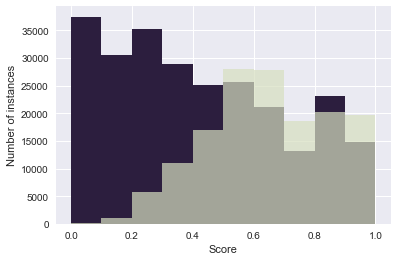

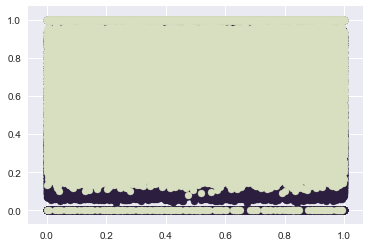

In [11]:
print np.max(scores_eq), np.min(scores_eq)
print scores_eq[sy == 1].mean()
print scores_eq[sy == 0].mean()

pal = sns.cubehelix_palette(10, start=.5, rot=-.75)
bcolor, rcolor = pal[0], pal[9]

plt.hist(scores_eq[sy == 0], color=rcolor)
# plt.show()
plt.hist(scores_eq[sy == 1], color=bcolor, alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Number of instances')
plt.show()
plt.scatter(np.linspace(0, 1, scores_eq[sy == 0].shape[0]), scores_eq[sy == 0], color=rcolor)
plt.scatter(np.linspace(0, 1, scores_eq[sy == 1].shape[0]), scores_eq[sy == 1], color=bcolor)

In [11]:
print uniques_eq.shape
numuniques = np.array([float(len(i)) for i in uniques_eq])
scaler = StandardScaler()
numuniques = scaler.fit_transform(numuniques.reshape(-1, 1))
print numuniques.max(), numuniques.min()
print numuniques[sy==0].mean()
print numuniques[sy==1].mean()

(404290,)
19.4880685533 -1.2239870253
0.276607706404
-0.472604955957


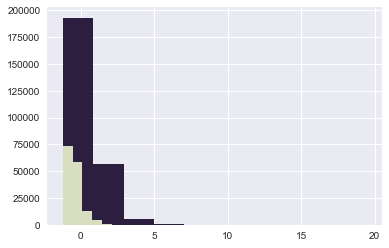

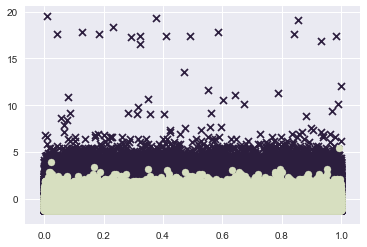

In [13]:
plt.hist(numuniques[sy == 0], color=rcolor)
# plt.show()
plt.hist(numuniques[sy == 1], color=bcolor)
plt.show()

plt.scatter(np.linspace(0, 1, numuniques[sy == 0].shape[0]), 
                numuniques[sy == 0], color=rcolor, marker='x')
plt.scatter(np.linspace(0, 1, numuniques[sy == 1].shape[0]), 
                numuniques[sy == 1], color=bcolor)
plt.show()

In [12]:
def get_weights(X, commons):
    tfidf = TfidfVectorizer()
    woo = []

    for i in X:
        woo.append(' '.join(i[0]) + ' ')
        woo.append( ' '.join(i[1]) + ' ')

    m = tfidf.fit(woo)
    words = m.get_feature_names()
    vals = dict(zip(words, m.idf_))

    weights = np.zeros((X.shape[0], 1))
    print weights.shape, X.shape
    
    for j, i in enumerate(X):
        w1, w2, w3 = 0.0, 0.0, 0.0
        for v in i[0]:
            w1 += vals[v]
        for v in i[1]:
            w2 += vals[v]
        
        for v in commons[j]:
            w3 += vals[v]

#         weights.append(abs(w1-w2))
        try:
            weights[j] = w3 / (w1 + w2)
        except ZeroDivisionError:
            weights[j] = w3
            
#     weights = np.array(weights)

    return weights, vals

In [13]:
def get_char_count_diff(X):
    def get_diff(v):
        return abs(len(str(v[0])) - len(str(v[1])))
    
    diffs = np.apply_along_axis(get_diff, 1, X)
    
    return diffs

In [14]:
CLKMEASURE = 0
nlp = spacy.load('en', parser=False, entity=False)

In [15]:
def get_noun_count(X):
    global CLKMEASURE
    CLKMEASURE = 0
    
    def extract_nouns(v):
        global CLKMEASURE
        CLKMEASURE += 1
        stdout.write('{}/{}\r'.format(CLKMEASURE, X.shape[0]))
        return len([x for x in nltk.pos_tag(v[0]) if x[1] == 'NN' or x[1] == 'NNP'])
    
    return np.apply_along_axis(extract_nouns, 1, X.reshape(-1, 1))

In [16]:
CLKMEASURE = 0
def spacy_sim(X):
    global CLKMEASURE
    CLKMEASURE = 0
    def get_sims(v):
        global CLKMEASURE
        CLKMEASURE += 1
        
        vs0 = str(v[0])
        vs1 = str(v[1])
        d1 = nlp(unicode(vs0.decode('utf-8')))
        d2 = nlp(unicode(vs1.decode('utf-8')))
        sim = d1.similarity(d2)
        stdout.write('{}/{}\r'.format(CLKMEASURE, X.shape[0]))
        return sim
    
    return np.apply_along_axis(get_sims, 1, X)

In [17]:
def get_spacy_noun_count(X):
    global CLKMEASURE
    CLKMEASURE = 0
    
    def extract_nouns(v):
        global CLKMEASURE
        CLKMEASURE += 1
        stdout.write('{}/{}\r'.format(CLKMEASURE, X.shape[0]))

        vs0 = ' '.join(v[0])
        d = nlp(unicode(vs0.decode('utf-8')))
        
        nouns = [x for x in d if (x.tag_ == 'NN' or x.tag_ == 'NNP')]
#         print nouns
        return len(nouns)
    
    return np.apply_along_axis(extract_nouns, 1, X.reshape(-1, 1))

In [398]:
t = time.clock()
noun_count_train = get_noun_count(uniques_eq[:100])
print time.clock() - t
print noun_count_train

0.144022
[1 2 4 2 7 4 2 0 0 2 5 0 0 0 1 2 1 2 0 3 1 2 1 3 4 2 1 3 1 1 0 1 0 5 1 4 2
 3 1 4 3 0 0 2 1 2 7 5 0 0 2 0 1 2 2 0 0 1 1 0 2 1 5 0 0 3 1 0 1 5 1 0 1 6
 0 9 1 5 1 0 8 5 8 0 3 1 1 4 1 0 4 2 1 1 0 0 2 1 9 2]


In [18]:
t = time.clock()
sims = spacy_sim(X)
print time.clock() - t
print sims

292.539608290
[ 0.99654587  0.93444557  0.93191186 ...,  0.94499402  0.80907542
  0.98751808]


In [19]:
weights, weight_dict = get_weights(cl, commons_eq)
char_diff = scaler.fit_transform(get_char_count_diff(sX).reshape(-1, 1))
word_diff = scaler.fit_transform(get_char_count_diff(cl).reshape(-1, 1))
print weights[0:5]

(404290, 1) (404290, 2)


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



[[ 0.47871414]
 [ 0.3338373 ]
 [ 0.1010657 ]
 [ 0.        ]
 [ 0.10118467]]


In [20]:
t = time.clock()
nouns_spacy = get_spacy_noun_count(uniques_eq)
print time.clock() - t

97.1127584290


NameError: name 'weighted_nouns' is not defined

In [21]:
# ncopy = copy(noun_count_train)
# noun_count_train_eq = scaler.fit_transform(noun_count_train.reshape(-1, 1))
nouns_spacy_eq = scaler.fit_transform(nouns_spacy.reshape(-1, 1))

In [22]:
tttX = sX[np.all(np.c_[scores_eq >= 0.7, sy == 0], axis=1)]
print tttX[:5]

[['What is the step by step guide to invest in share market in india?'
  'What is the step by step guide to invest in share market?']
 ['When do you use \xe3\x82\xb7 instead of \xe3\x81\x97?'
  'When do you use "&" instead of "and"?']
 [ 'What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?'
  'What are the laws to change your status from a student visa to a green card in the US? How do they compare to the immigration laws in Japan?']
 [ 'What are some tips on making it through the job interview process at Medicines?'
  'What are some tips on making it through the job interview process at Foundation Medicine?']
 ['What is web application?' 'What is the web application framework?']]


In [23]:
def accuracy(model, XX, sy, label=None):
#     p = model.predict(XX)

    proba = model.predict_proba(XX)
    p = np.argmax(proba, axis=1)
    p_probs = np.max(proba, axis=1)
    
    comb = np.all(np.c_[p.astype(bool), sy.astype(bool)], axis=1)
    
    tp = p[np.all(np.c_[sy == 1, p == 1], axis=1)].shape[0]
    tn = p[np.all(np.c_[sy == 0, p == 0], axis=1)].shape[0]
    fp = p[np.all(np.c_[sy == 0, p == 1], axis=1)].shape[0]
    fn = p[np.all(np.c_[sy == 1, p == 0], axis=1)].shape[0]
    total = XX.shape[0]
    pos_count = sy[sy==1].shape[0]
    neg_count = sy[sy==0].shape[0]
    
    if label:
        print "----{}----".format(label)
        print
        
    print "True pos {0}/{1}".format(tp, pos_count)
    print "True neg {0}/{1}".format(tn, neg_count)
    print "False pos {0}/{1}".format(fp, neg_count)
    print "False neg {0}/{1}".format(fn, pos_count)
    
    print "Recall", tp/(tp+fp)
    print "Precision", tp/(tp+fn)
    print 'Accuracy, {}'.format((tp+tn)/total)
    print "Log loss", log_loss(sy.astype(int).ravel(), p_probs.ravel())


In [89]:
XX = np.c_[numuniques, weights, word_diff, char_diff, nouns_spacy_eq, sims]
XX_1 = np.c_[weights, word_diff, char_diff, nouns_spacy_eq, sims]
XX_2 = np.c_[weights, word_diff, nouns_spacy_eq, sims]

In [90]:
gb = GaussianNB()
m = gb.fit(XX_3, sy.astype(int))

accuracy(m, XX_3, sy, "Naive Bayes")

----Naive Bayes----

True pos 110082/149263
True neg 157538/255027
False pos 97489/255027
False neg 39181/149263
Recall 0.530334198901
Precision 0.737503601026
Accuracy, 0.661950580029
Log loss 2.00355374453


In [73]:
gb = GradientBoostingClassifier()
mgb = gb.fit(XX_2, sy.astype(int))

accuracy(mgb, XX_2, sy)

True pos 102536/149263
True neg 187270/255027
False pos 67757/255027
False neg 46727/149263
Recall 0.602115177958
Precision 0.686948540496
Accuracy, 0.716827030102
Log loss 1.5632379796


In [94]:
pos_train = XX_2[sy == 1]
neg_train = XX_2[sy == 0]

p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1

while scale > 1:
    neg_train = np.r_[neg_train, neg_train]
    scale -=1
    
neg_train = np.r_[neg_train, neg_train[:int(scale * len(neg_train))]]
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = np.r_[pos_train, neg_train]

y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.191243661001


In [95]:
# x_train, x_valid, y_train, y_valid = train_test_split(XX, sy.astype(int), test_size=0.2, random_state=4242)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.08
params['max_depth'] = 6
params['min_child_weight'] = 1

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=25)

[0]	train-logloss:0.656432	valid-logloss:0.656671
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[25]	train-logloss:0.408659	valid-logloss:0.41147
[50]	train-logloss:0.390904	valid-logloss:0.394521
[75]	train-logloss:0.388476	valid-logloss:0.392543
[100]	train-logloss:0.387668	valid-logloss:0.392058
[125]	train-logloss:0.386695	valid-logloss:0.391492
[150]	train-logloss:0.385532	valid-logloss:0.390824
[175]	train-logloss:0.384793	valid-logloss:0.3905
[200]	train-logloss:0.384161	valid-logloss:0.390242
[225]	train-logloss:0.383726	valid-logloss:0.390036
[250]	train-logloss:0.383268	valid-logloss:0.389792
[275]	train-logloss:0.382898	valid-logloss:0.389672
[300]	train-logloss:0.382601	valid-logloss:0.389568
[325]	train-logloss:0.382244	valid-logloss:0.389419
[350]	train-logloss:0.381971	valid-logloss:0.389329
[375]	train-logloss:0.381655	valid-logloss:0.389221
[399]	train-logloss:0.381

In [27]:
woo = xgb.DMatrix(XX[0:3])
print bst.predict(woo)
print sy[0:3]

[ 0.49063474  0.67052835  0.17352283]
[0 0 0]


In [29]:
# cl_test = []
testX = test.drop('test_id', axis=1).as_matrix()

# for i, v in enumerate(testX):
#     stdout.write(str(i+1) + '/' + str(testX.shape[0]) + '\r')
#     cl_test.append([clean(v[0]), clean(v[1])])

# print 'Done cleaning'
# cl_test = np.array(cl_test)

In [26]:
with open('cleaned_test_matrix.pkl') as f:
#     pickle.dump(cl_test, f)
    cl_test = pickle.load(f)

In [30]:
commons_test, uniques_test, scores_test = create_commons(cl_test)
numuniques_test = np.array([float(len(i)) for i in uniques_test])
weights_test = get_weights(cl_test, commons_test)
char_diff_test = get_char_count_diff(testX)
word_diff_test = get_char_count_diff(cl_test)
nouns_test = get_spacy_noun_count(uniques_test)
sims_test = spacy_sim(testX)

# x_test = np.c_[numuniques_test, weights_test, word_diff_test, char_diff_test]

(2345796, 1) (2345796, 2)


In [17]:
# weights_test = get_weights(cl_test, commons_test)
# char_diff_test = get_char_count_diff(testX)
# word_diff_test = get_char_count_diff(cl_test)

# x_test = np.c_[numuniques_test, weights_test, word_diff_test, char_diff_test]

(2345796, 1) (2345796, 2)


In [61]:
x_test = np.c_[numuniques_test, weights_test[0], word_diff_test, char_diff_test, nouns_test, sims_test]
x_test_1 = np.c_[weights_test[0], word_diff_test, nouns_test, sims_test]

In [96]:
d_test = xgb.DMatrix(x_test_1)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('saumitra_quora_xgb_6.csv', index=False)

In [43]:
fi = bst.predict(d_train)
fi[fi > 0.5] = 1
fi[fi < 1] = 0

fiprobs = np.in1d(sy, fi)
print fiprobs.shape
print sy.shape
print fiprobs[fiprobs == True].shape[0]/sy.shape[0]

(404290,)
(404290,)
1.0
